# Background

In [1]:
# This cell is tagged for removal

import os
import math
import pickle
from glob import glob

import numpy as np
import pandas as pd
from IPython import display as idisplay

import aliases # important this goes first to configure PATH

from everest.window import Canvas, plot, raster, DataChannel as Channel, get_cmap
from everest.window.colourmaps import *
from everest.window import image, imop

from referencing import search
from myst_nb import glue
from analysis import isovisc, arrhenius, utilities, common, analysis, visualisation
%matplotlib inline

osjoin = os.path.join

import warnings

warnings.filterwarnings("ignore",category=UserWarning)

For over half a century now, geodynamicists have accepted that the interior of the Earth and other planets can to some degree be formalised as a variant of Rayleigh-Benard convection amenable to numerical simulation {cite}`Mckenzie1974-wb`. While early modelling efforts were focussed on simple rheologies and geometries out of necessity, increasing hardware and software capabilities have since allowed modern investigators to target much more sophisticated behaviours in the search for a truly Earth-like rheology, including strain-rate dependence {cite}`Moresi1998-az,Zhong1998-qg`, magmatic history {cite}`ONeill2018-hy`, chemical phases {cite}`Tackley2012-hq`, and more.

The constant drive for increased model complexity comes at the expense of fundamental knowledge of the simpler rheologies which these more advanced systems are ultimately built over: ironic, as modern resources are only now able to support the breadth and detail that early authors would have preferred. There are two major contributors to this 'complexity preference' in the modelling literature:
1. It is easier to argue that a new rheology represents novel work worth publishing.
2. It is logistically less tiresome to orchestrate a small suite of large models than a large suite of small models.

While there is not much to be done about the first factor, which plagues every academic literature, the second factor calls only for effort and invention. It suggests a particular lack of a particular capability: the means to design, operate, and analyse a modelling survey at a much higher level of abstraction.

In this section it will be shown how the state of the art has developed over time with respect to linear rheologies in mantle convection, both in terms of analytical comprehension and numerical simulation. All pre-existing data regarding our parameter space of interest will be reviewed and any shortcoming or contradictions highlighted and discussed. Finally, the question of modelling strategy will be considered, and the essential demands of the problem underlined.

## Basics of convection

The essential model of planetary solid-state circulation is Rayleigh-Benard convection, in which a fluid held between two plane layers of different temperatures is observed to spontaneously self-organise into counter-rotating cells to maximise the efficiency of transport {cite}`Getling1998-gv`. Such a model is governed by three principal dimensionless quantities:
- The *Prandtl* number, the ratio of momentum diffusivity (or kinematic viscosity) $\nu$ to the thermal diffusivity $\kappa$:

$$ Pr = \frac{\nu}{\kappa} $$

- The *Reynolds* number, the ratio of inertial forces to viscous forces and hence a measure of flow turbulence (where $u$ is flow velocity and $L$ is a length scale):

$$ Re =\frac{u L}{\nu} $$

- And the *Rayleigh* number, the product of $Pr$ and $Re$, interperable as the ratio of buoyancy forces to viscous forces in the fluid (with thermal expansivity $\alpha$, gravity $g$, thermal gradient $\Delta T$, and length scale $D$):

$$ Ra = \frac{\alpha g \Delta T D^3}{\kappa \nu} $$

In addition to these three input variables, one unifying output variable - also dimensionless - commonly enters into the analysis, and will prove an essential razor throughout this thesis: the *Nusselt* number, a measure of the efficiency of global thermal transport relative to that expected by conduction alone. It can be given in terms of the rate of change of the dimensionless potential temperature $\theta^*$ with respect to dimensionless depth $y^*$ {cite}`Schubert2001-ea`:

$$ Nu = 1 + \left| \frac{\partial \theta^*}{\partial y^*} \right| _S $$

Where $|x|_S$ indicates the average value across a surface. The asterisks indicate a non-dimensionalised quantity: a common textbook convention. (In non-curved domains, $Nu$ is equivalent to the dimensionless surface temperature gradient, and it is confusingly defined as such in some contexts {cite}`Blankenbach1989-li`.)

Because any convection of interest to us in the mantle is going to be occurring in the solid state, across great distances, and under tremendous heat gradients, we are able to make certain assumptions that simplify the analysis. Two are commonly made:
- The *Boussinesq* approximation, in which non-gravitational terms of density are ignored, with the consequence that the fluid is incompressible. This is a justifiable assumption for just about any non-gaseous fluid, particularly one subjected to such extreme lithostatic pressures.
- The infinite *Prandtl* assumption, in which momentum diffusivity is held to be much greater than thermal diffusivity. This is reasonable for the mantle given the measured value comes to at least $10^{23}$ {cite}`Schubert2001-ea`. Because $Pr \cdot Re = Ra$, this also implies that the *Reynolds* number must be infinitesimal, and hence that inertial forces and the turbulent effects thereof are negligible.

These two simplifications have many consequences. For one, they allow the four dimensionless parameters above to be collapsed to only two: the *Rayleigh* number $Ra$ and the *Nusselt* number $Nu$. It will shortly become clear that these two quantities actually bear a power-law relation through a third property, the '*beta* exponent' $\beta$, that in a single stroke unifies the intrinsic and extrinsic characteristics of planetary thermal transport:

$$ Nu \propto Ra^{\beta}$$

This elegant law forms the analytical cornerstone of our work.

Though we ground ourselves in theory, our method is empirical. Thankfully, the scheme we have laid out also provides a powerful framework for numericisation: by eliminating inertial, compressive, and turbulent forces, we are able to construct mantle convection as a kind of Stokes Flow under the body forcing of gravity $g$, limited by conservation of mass and iterated by advection-diffusion, and so captured by the equations:

$$ \begin{align*}
\nabla p - \nabla \left( \eta D \right) &= \Delta \rho \mathbf{g} \\
\nabla \cdot \mathbf{u} &= 0 \\
\frac{\partial T}{\partial t} + \mathbf{u} \cdot \nabla T &= \kappa \nabla^2 T + H \\
\end{align*} $$

Where $\eta$ is dynamic viscosity, $D$ the strain rate tensor, $p$ dynamic pressure, $\Delta\rho$ the density anomaly, $\mathbf{g}$ the gravity vector, $\mathbf{u}$ the velocity vector, $T$ temperature, $\kappa$ thermal diffusivity, $t$ time, and $H$ a thermal source term, i.e. radiogenic heating.

With these equations, we may implement an alternating cycle of instaneous pressure solutions followed by finite time-stepping of the temperature field (and any other state variables we choose to implement). Of course, such a system is meaningless and insoluble unless we further stipulate a geometry (width, length, depth, and curvature) and a set of boundary conditions for the temperature and velocity fields. The boundary conditions on each outer domain surface are typically set to be either:
- Fixed in value (a 'Dirichlet' condition). For the temperature field, this would imply that the core and/or the space-facing surface of the planet are infinite thermal buffers. For the velocity field, this can be used - for example - to define surfaces that are impervious in the normal component and either no-stick, perfect-stick, or tractional in the parallel component.
- Fixed in gradient (a 'Neumann' condition): for the temperature field, this would imply that the surface radiates heat at a fixed power, which in the case of zero power would make that boundary effectively insulating; for the velocity field, this essentially configures the strain rate in the chosen component.

With respect to temperature, either of the above conditions can be set to inject or remove heat from the model, which - in tandem with the internal heat function $H$ - provides the fluid with the thermal situation its flow is expected to resolve, given sufficient time. On Earth, we imagine mantle convection and the interconnected phenomenon of surface tectonics to represent the Earth's own natural solution, or solution-in-progress, to the circumstance of volumetric radiogenic heating and basal heating from the core, although the debate over the relative significance of these is ancient and ongoing {cite}`Thomson1862-kb,Urey1955-zs,Korenaga2003-oy,Korenaga2008-js,Gando2011-sh,Mareschal2012-ie,Huang2013-eu,jaupart 2015,`. (For the models being discussed forthwith, we have restricted ourselves to free-slip velocity boundaries and Dirichlet thermal boundaries with a constant unit temperature gradient from top to bottom, such that the heating regime is always either purely basal or mixed.)

Within these simplifying constraints, almost limitless variety is possible - which is why this essential formulation has become common to virtually all studies of mantle convection. However, while it is hoped that somewhere within problem-space a solution resembling Earth may be found, such a solution must elude us until our grasp of the fundamentals is absolute; and there is still much about even the simplest rheologies that we do not understand.

## Linear rheologies

When we talk about rheology, or a materials' style of flow, we are primarily talking about its viscosity function - the expression that maps the local viscosity at any point in the fluid to its context, history, or environment. While most fluids in the real world have complex 'Non-Newtonian' rheologies in which pressure and viscosity are co-dependent, mantle convection studies have often relied on simpler Newtonian rheologies that are more numerically and analytically tractable. These are what we here call 'linear rheologies'.

The bulk of all mantle convection studies focus on one of the following three linear rheologies:
- **Isoviscous** or 'constant viscosity' flow.
- **Arrhenius**-type exponentially temperature-dependent viscosity.
- **Spatialised** viscosity - either arbitrarily zoned or simply depth-dependent.

For our investigation, we focussed on the Isoviscous and Arrhenius types, which we will now discuss in more detail.

### Isoviscous rheology

Due to their simplicity and amenability to symbolic analysis, isoviscous models were among the earliest published mantle convection models {cite}`McKenzie1973-gt,McKenzie1974-wb,Jarvis1986-me,Blankenbach1989-li`, and they continue to be produced and discussed today {cite}`Zhong2005-lh,Weller2016-ej,Weller2016-nm,Vilella2018-il`.

In an isoviscous model, the viscosity function (usually set to $\eta=1$) is constant throughouts space and time. Though simple, it is nevertheless albe to reproduce appropriate surface velocities, gravitational profiles, and even topographic wavelengths {cite}`McKenzie1973-gt,McKenzie1974-wb`. Though its parameters are few, there remain limitless possible variations through *Rayleigh* number, internal heat $H$, domain geometry, and choice of boundary condition - many of which boast long-term stability solutions with enough implicit nonlinearity to make purely analytical studies infeasible {cite}`Daly1980-xl`. And while the isoviscous model is certainly the most computationally tractable of all mantle-like rheologies, it is only in the last decade that simulations of appropriate scale for the Earth ($Ra>10^7$) have become possible {cite}`Vynnycky2013-wg,Trubitsyn2018-jo`; these have confirmed earlier intuitions that stable convective planforms may either not exist, or may never manifest, on planetary spatiotemporal scales {cite}`Huttig2011-jt`.

Although the model does bely considerable complexity, it is simple enough to make some solutions analytically attainable. Like all convecting systems, a 'critical' *Rayleigh* number $Ra_{cr}$ should exist below which convection ceases and conduction dominates (i.e. $Nu=1$), defining a 'supercritical $Ra$':

$$ R \equiv \frac{Ra}{Ra_{cr}} $$

At $R=1$, perturbations of a certain 'critical' wavelength are uniquely able to grow faster than the conductive geotherm and hence become unstable; increasing $R$ beyond $1$ makes more wavelengths available for convective growth,  until at extreme values ($Ra >> 10^7$) even artificial heterogeneities introduced by random noise can grow, such that large-scale models become overwhelmingly time-dependent {cite}`Jarvis1984-xo`. For a plane domain of infinite horizontal extent, the critical wavelength $\lambda_{cr}$ should be exactly $\sqrt{2}$ {cite}`Chandrasekhar1961-ez`, corresponding to a $Ra_{cr}$ of exactly {cite}`Malkus1954-ee`:

$$ Ra_{cr} = \frac{27\pi^4}{4} \approx 657.5 $$

In any real system, however, $A$ cannot be infinite, and may be literally or effectively compressed such that the critical wavelength is no longer available. The effect of this is to create a dependency of $Ra_{cr}$ on $A$ {cite}`Chandrasekhar1961-ez`:

$$ Ra_{cr} = \frac{\pi^4 \left( 1 + A^2 \right)^3}{A^4} $$

At the unit aspect ratios typically modelled, for instance, $Ra_{cr}$ should instead approach ({cite}`Grover1968-wa`):

$$ Ra_{cr} = 2^3\pi^4 \approx 779.3 $$

A value which is borne out in laboratory testing {cite}`Whitehead2011-gs`.

If an isoviscous system does stabilise, the symmetry of the system requires that the upper and lower thermal boundaries become identical, 180-degree rotations of one another. Using Boundary Layer Theory {cite}`Olson1987-do` - the sub-analysis of arbitrarily thin layers at domain margins - a family of such stable planforms can be identified which follow a simple scaling law, mentioned previously and expounded in the textbook literature {cite}`Schubert2001-ea`:

$$ Nu \propto Ra^{\beta}, \quad \beta \to \frac{1}{3} $$

Where $Nu$ is the Nusselt number. The coefficient of proportionality is theoretically $\approx 0.1941$ {cite}`Olson1987-do`, though it has been argued that its value will tend be dominated by uncertainty in practice {cite}`Lenardic2003-wd`; reported values have ranged between $0.25-0.27$ {cite}`Olson1987-do,Jarvis1989-qj`.

An equivalent scaling {cite}`Jarvis1982-ua` has instead:

$$ Nu \propto R^{\beta} $$

Where $R$, again, is the proportion by which $Ra$ exceeds $Ra_{cr}$. Defining $Ra$ in this way preserves the value of $\beta$ but allows the coefficient to relate more strictly to non-thermal factors like the domain geometry, particularly the aspect ratio, which has been observed to stretch or compress the planform horizontally without changing the underlying boundary stability criteria {cite}`Jarvis1982-ua`.

In any case, at the state where $Nu$ satisfies this scaling, the interior of each cell becomes a homogeneous region of uniform temperatures and low velocities, with strong gradients and shears at the margins, with the overall cell dimensions approaching an aspect ratio of $\sqrt{2}$. Because of the fixed temperature scale, the only way heat transport can be enhanced is by thinning the boundary layers, which in practice occurs by dripping/pluming until only the theoretical stable boundary thickness is left. For this reason, $Nu$ also functions as a useful proxy for boundary layer thickness when this is otherwise hard to define.

The canonical *beta* scaling is seductive because it connects the relatively well-constrained fact of surface geothermal flux with the more mysterious thermal state of the mantle, and so allows parameterised thermal histories to be projected through deep time. The $\beta \to \frac{1}{3}$ limit itself ultimately derives from the *Rayleigh* number's dependence on length cubed, and while there is no *a priori* reason to believe that this analytical justification must be borne out in practice, it has been recognised as extremely suggestive for over half a century {cite}`Chan1971-xv`. Testing this scaling behaviour empirically was an early priority of computational geodynamics, with several studies producing estimates that converged on, but did not achieve, the theoretical $\frac{1}{3}$ scaling: the value has been reported as any of $0.313$ {cite}`Jarvis1982-ua`, $0.318$ {cite}`Jarvis1986-me`, $0.319$ {cite}`Schubert1985-sy`, $0.326$ {cite}`Jarvis1989-qj`, and $0.36$ {cite}`Quareni1985-ff`, using various methods. The reason for the deviation is uncertain. It was for a time suggested that, at very high *Rayleigh* numbers, an 'asymptotic regime' of $\beta \to \frac{1}{2}$ might emerge, which might help explain the apparent 'thermal catastophe' of the Early Earth {cite}`Urey1955-zs`; however, a definitive laboratory study using liquid helium {cite}`Niemela2000-cu` found that there is no such transition within $Ra<=10^7$, and reported instead an empirical value of $0.31$ for the interval $Ra: 10^6 - 10^7$, in close agreement with numerical results.

While the *beta* scaling strictly holds only for those isoviscous systems with purely basal (no volumetric) heating, Cartesian geometry, and free-slip boundaries, it has been found to hold for a wide range of systems if certain corrections are made.

#### Isoviscous rheology in cylindrical geometry

##### Defining a coordinate system

If the domain is allowed to curve around the $z$ axis, a cylindrical or annular geometry is obtained which is more appropriate for planetary mantles. The curavture is defined by the ratio of radii $f$, where $f=1$ is equivalent to a Cartesian box, $f\to0$ becomes a complete wedge, and the values $\sim 0.5$ and $\sim 0.9$ would be appropriate for the whole mantle and upper mantle respectively:

$$ f \equiv \frac{r_{inner}}{r_{outer}} $$

(Equivalently, the ratio of circumferences may be used.)

To navigate the curved geometry, a curved coordinate system is called for. Vertical distance becomes radial distance, which is typically restricted in the unit interval - i.e.:

$$ r_{outer} - r_{inner} = 1 $$
$$ \begin{align*}
r_{inner} &= \frac{f}{1 - f} \\
r_{outer} &= \frac{1}{1 - f}
\end{align*} $$

(Note that this would imply infinite planetary radii at $f=1$ - hence the planar-like endmember is not strictly reachable under an assumption of curvature, though arbitrarily high values can be set to reproduce that behaviour.)

The inner and outer lengths $s$ would then be:

$$ \begin{align*}
s_{inner} &= 2\pi\frac{f}{1 - f} \\
s_{outer} &= 2\pi\frac{1}{1 - f}
\end{align*} $$

Of course, often we will only want to reproduce a small wedge of the annulus, as time-dependence and numerical workload scale exponentially with aspect ratio. We can define our wedge selection $D$ in radians:

$$ \theta: 0 \to D, \quad D \leq 2\pi $$

If the simulation is to represent periodic flow around the annulus, values of $D$ must satsify $\pi / l$, where $l$ is a positive integer representing the number of convection cell pairs it would take to populate the full annulus at equivalent curvature (i.e. the number of upwellings or downwellings). If we require a definition of aspect ratio $A$ in the annulus, it is convenient to set this as the arc length through the mid-depth, which then relates to $D$ and $f$ via a new term, $F$, equivalent to the radial distance $r$ from the planetary centre of gravity to the mantle mid-depth:

$$
F \equiv \frac{r_{inner} + r_{outer}}{2} = \frac{1 + f}{2 \left( 1 - f \right)} \\
A = FD
$$

A virtue of this definition is that the area of the domain remains constant when $A_f$ is constant, regardless of the curvature $f$. Unfortunately, it also leaves us with two competing claims for a 'natural' denominator of the angular coordinate, $D$ and $F$.  While authors have sometimes preferred to keep $D$ and $F$ constant and allow $A$ to vary {cite}`Jarvis1994-np`, we have for the most part chosen to fix $A$ and $F$ with $D$ as the free parameter, as in {cite}`Jarvis1993-cb`: this simplifies comparisons with plane-layer simulations at the cost of producing planforms which would be unstable if scaled to the full annulus.

##### Effects on conduction and instability

The curvature $f$ immediately affects the expected conductive geotherm: where in a Cartesian box, the flux goes constantly with depth $\phi_q \propto \Delta T$, with curvature it becomes variable with planetary radial height $r$ as the flux is progressively spread out over increasing area:

$$ \phi_q \propto \frac{-1}{r \ln f} $$

(Note that this would imply $\phi_q\to\infty$ a $f\to1$.)

/home/morpheus/workspace/mount/resources/everest/everest/window/canvas.py:91: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.fig.tight_layout()
/home/morpheus/workspace/mount/resources/everest/everest/window/canvas.py:91: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.fig.tight_layout()


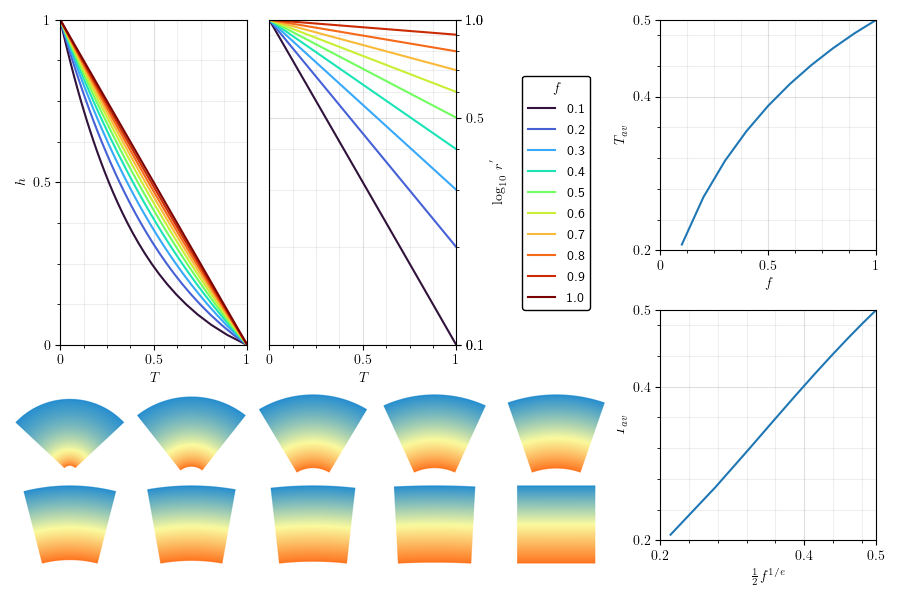

In [2]:
# fs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# geotherms = []
# condavts = []
# for f in fs:
#     system = Isovisc(alpha = 1., f = f, res = 32)
#     system.initialise()
#     temp = system.locals.temperatureField
#     diff = system.locals.diffusivityFn
#     cond = pfn.conduction.default(temp, 0, diff)
#     condavt = pfn.integral.volume(cond).data
#     left = pfn.surface.left(cond)
#     fig = QuickFig(cond, background = 'white', edgecolour = 'white')
#     geotherms.append(left.data)
#     condavts.append(condavt)
#     fig.save('cond_f' + str(f).replace('.', '-'))
# out = {
#     'fs': fs,
#     'geotherms': geotherms,
#     'avts': condavts,
#     }
# with open('cond.pkl', mode = 'wb') as file:
#     file.write(pickle.dumps(out))

impaths = sorted(os.path.relpath(path) for path in glob(osjoin(aliases.storagedir, 'cond*.png')))
ims = tuple(image.fromfile(path) for path in impaths)
thumbs = imop.vstack(
    imop.hstack(*ims[:5]),
    imop.hstack(*ims[5:]),
    )

with open(osjoin(aliases.storagedir, 'cond.pkl'), mode = 'rb') as file:
    conddata = pickle.loads(file.read())
condgeotherms, condavts, condfs = (conddata[key] for key in ('geotherms', 'avts', 'fs'))

canvas1 = Canvas(shape = (1, 2), size = (6, 4))

ax1 = canvas1.make_ax((0, 0))
ax2 = canvas1.make_ax((0, 1))

for f, T in zip(condfs, condgeotherms):

    f = min(0.999, f)

    h = np.linspace(0, 1, len(T))
    rinner, router = f / (1 - f), 1 / (1 - f)
    rprime = (h + rinner) / router # equiv to (h * (1 - f) + f)

    ax1.line(
        Tchan := Channel(T, label = 'T'),
        Channel(h, label = 'h'),
        c = cmap(f, condfs, style = 'turbo'),
        )

    ax2.line(
        Tchan,
        Channel(rprime, label = r"r^{'}", capped = (True, True), log = True),
        c = cmap(f, condfs, style = 'turbo'),
        )

ax2.props.edges.y.swap()

ax2.props.legend.set_handles_labels(
    (row[0] for row in ax1.collections),
    (str(f) for f in condfs),
    )
ax2.props.legend.title.text = 'f'
ax2.props.legend.title.visible = True
ax2.props.legend.mplprops['bbox_to_anchor'] = (1.75, 0.85)
# ax1.props.legend.mplprops['ncol'] = 2
ax2.props.legend.frame.colour = 'black'
ax2.props.legend.frame.visible = True

canvas2 = Canvas(size = (3, 6), shape = (2, 1))

ax1 = canvas2.make_ax(place = (0, 0))
ax1.line(
    Channel(condfs, label = 'f', lims = (0, 1.), capped = (True, True)),
    Tchan := Channel(condavts, label = 'T_{av}', lims = (0.2, 0.5), capped = (True, True)),
    )

def func(f):
    return 0.5 * f ** (1. / math.e)
ax2 = canvas2.make_ax(place = (1, 0))
ax2.line(
    Channel(list(map(func, condfs)), label = r'\frac{1}{2}f^{1/e}', lims = (0.2, 0.5), capped = (True, True)),
    Tchan,
    )

# fig = imop.hstack(imop.vstack(canvas1, thumbs), canvas2)
fig = imop.paste(
    imop.hstack(canvas1, canvas2, pad = (255, 255, 255)),
    imop.resize(thumbs, size = 0.19),
    coord = (0.01, 0.95),
    corner = 'bl',
    )
display(fig)

Because the temperature gradient goes with $\phi_q$ inversely to area, and so $r$, and so $f$, this implies that the conductive geotherm at the upper boundary will be lesser than at the lower boundary by a factor of exactly $f^2$: the two boundaries are no longer symmetrical. To evaluate convective instability, then, we must treat with each boundary independently.





If we make the assumption that, as in the planar case, the convective steady state will eventually result in a broad intracellular region of uniform temperature $T_{cell}$, we can define this temperature as a function only of $f$. If the total temperature drop is held to be unit, and given that ratio of upper and lower boundary gradients must be exactly $f^2$, it follows that:

$$
\frac{\Delta T_{outer}}{\Delta T_{inner}} = \frac{T_{cell}}{1 - T_{cell}} = f^2 \\
T_{cell} = \frac{f^2}{f^2 + 1}
$$

For a mantle-like curvature of $f=0.5$, then, we would expect an average dimensionless temperature of $0.2$, regardless of the *Rayleigh* number.

Another important consequence of the altered geotherm follows that $Nu$ is no longer equivalent to the dimensionless temperature gradient, but rather scales from it by a function of $f$:

$$ Nu = \frac{\ln f}{1 - f} \cdot \left| \frac{\partial T}{\partial r} \right| _{S} $$

Where $|x|_S$ again represents the average value across a surface.

The same factors of decreasing $f$ drive a decrease in intracellular temperatures, and hence global average temperatures {cite}`Jarvis1994-np`:

$$ T_{av} = \frac{1}{\left( 1 + f^{-3/4} \right)} $$

When considering convection in a cylindrical domain, the immediate qualitative difference resulting from curvature is the asymmetry of the two boundary layers. The additional space at the top of the model now allows more room for downwellings relative to basal upwellings, tending to promote instability {cite}`Jarvis1991-ir`; on the other hand, the curved geotherm and the increased surface for radiating heat would tend to permit a comparatively thicker upper boundary layer. The effect of these countervailing forcings on the fundamental scaling scaling relation $Nu \propto R^{\beta}$ is not obvious, but one analytical treatment by Jarvis {cite}`Jarvis1993-cb` combines the results obtained above to produce a 'geometric correction' $g(f)$, which enters the power law as a scaling coefficient:

$$
g(f) = \frac{\ln f}{1 - f} \cdot -\left( \frac{1}{1 + f^{-3/4}} \right) ^{4/3} \\
Nu = g(f) \cdot R^{\frac{1}{3}}
$$

Using this scaling, Jarvis was able to obtain a *beta* exponent of $0.321 \pm 0.001$ across four values of $f$ from $(1.0 - 0.1)$ {cite}`Jarvis1993-cb`.

To define $R=\frac{Ra}{Ra_{cr}}$ --- ?

In [ ]:
search('jarvis 1993')